# Measuring the Costs of COVID-19 Policies in Ontario
---

Given the onslaught of the COVID-19 pandemic, economics across the globe have necessitated lockdown procedures in order to slow infection rates to a level which is manageable given the hospital constraints of a nation. These lockdown procedures not only slowed the growth of the virus but also the growth of the economy. With the brakes on the economy, a cost arises, and a big one. Not only do costs form from the lack of production, but as well the cost of lives due to pandemic policy choices. The question then arises of what policies should be chosen? What are the costs associated with choosing certain policies over others? And whether lockdowns were actually worth it. To solve these questions a basic SIR model will be used along with available effective reproduction rate ($R_t$) data for the province of Ontario. With this we can adjust the levels of $R_t$ at different sections in time to account for varying policies. Although this is not a perfect method for looking at completely different strategies, it does give some valuable insight on changes to the strategy that has been used in Ontario. The use of the $R_t$ also allows many other variables such as, behaviour, mobility, and the effect of lockdowns, to be captured easily in one variable. Though less accurate, this gives an overall image of what could have happened given more minor changes to policy implementation and timing.

We will begin with the simple SIR model which will be used for the purpose of this paper. The SIR model breaks down into three stages, Susceptible, Infected, and Recovered. These three stages then become three equations, which builds the foundation of our model. The SIR model can then be built as a function in Python, which will be used to run our various scenarios. We then use another function that will solve the system of equations named above, as well allow us to path out the behaviour of these variables overtime. For the purpose of this paper the model will be adjusted to return the values time series of infections, cumulative burden, and deaths. Using available data from Ontario government’s data catalogue, the $R_t$ can be found and imported into our Python model. By feeding the $R_t$ data into the SIR model, we can see paths for infections, cumulative burden, and deaths.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

In [2]:
url = "https://data.ontario.ca/dataset/8da73272-8078-4cbd-ae35-1b5c60c57796/resource/1ffdf824-2712-4f64-b7fc-f8b2509f9204/download/re_estimates_on.csv"
re_estimates = pd.read_csv(url)

In [3]:
re_estimates

,region,date_start,date_end,Re,lower_CI,upper_CI
0,Ontario,2020-03-13,2020-03-19,2.98,2.64,3.35
1,Ontario,2020-03-14,2020-03-20,2.75,2.46,3.05
2,Ontario,2020-03-15,2020-03-21,2.61,2.37,2.87
3,Ontario,2020-03-16,2020-03-22,2.42,2.22,2.64
4,Ontario,2020-03-17,2020-03-23,2.30,2.12,2.48
...,...,...,...,...,...,...
652,Ontario,2021-12-25,2021-12-31,1.54,1.53,1.55
653,Ontario,2021-12-26,2022-01-01,1.50,1.49,1.51
654,Ontario,2021-12-27,2022-01-02,1.45,1.44,1.46
655,Ontario,2021-12-28,2022-01-03,1.37,1.36,1.38


In [4]:
def F(x, t, R0, alpha):
    
    # Setting up the variables as a vector
    s, i, r, d, c = x
    
    #We now allow the parameters to be a function of time
    #We can also handle a fixed value for the parameters
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    c = alpha(t) if callable(alpha) else alpha
    
    # Now Four equations of the model (derivatives over time)
    ds = - beta * s * i - ((c * s) * 0.9)
    di = beta * s * i - gamma * i
    dr = gamma * (1 - nu) * i + ((c * s) * 0.9)
    dd = nu * gamma * i
    dcb = gamma * i 
    
    return ds, di, dr, dd, dcb

In [5]:
def solve_path(R0, alpha, t_vec, x_init):
    
    #use a lambda function to express differential equations with time varying parameters
    G = lambda x, t: F(x, t, R0, alpha)
    
    #use numerical routine to solve the system of ordinary differential equations
    s_path, i_path, r_path, d_path, c_path = odeint(G, x_init, t_vec).transpose()

    return i_path, r_path, d_path, s_path, c_path

In [6]:
# initial conditions / incl. new state
i_0 = 1e-5
s_0 = 1 - i_0
r_0 = 0
d_0 = 0
c_0 = 0

x_0 = s_0, i_0, r_0, d_0, c_0
alpha = 0

#Defining time horizon
t_length = len(re_estimates.loc[:, "Re"])
t_vec = np.array([i for i in range(t_length)])

#Setting parameters
gamma = 1/10
nu = 0.025

pop = 14789778
R0 = re_estimates.loc[:, "Re"].values

In [7]:
Rt = lambda t: np.interp(t, t_vec, R0)

In [8]:
# making an array of dates for plotting
dates = re_estimates.loc[:, "date_start"].values

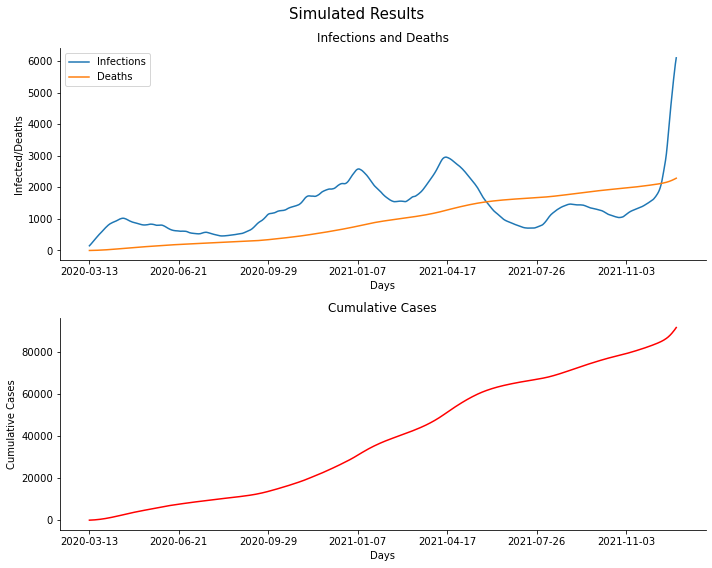

In [9]:
# i_path, c_path, d_path = solve_path(Rt, t_vec, x_0)
i_path, r_path, d_path, s_path, c_path = solve_path(Rt, alpha, t_vec, x_0)

fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(dates, i_path * pop, label="Infections")
ax[0].plot(dates, d_path * pop, label="Deaths")
ax[0].set_xticks(np.arange(0, len(re_estimates), 100))
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(dates, c_path * pop, color="red")
ax[1].set_xticks(np.arange(0, len(re_estimates), 100))
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)

ax[0].legend()
fig.suptitle("Simulated Results", fontsize=15)
plt.tight_layout()

In [10]:
url2 = "https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv"
covid_data_temp = pd.read_csv(url2)

In [11]:
covid_data = covid_data_temp.loc[36:692, ["Reported Date",  "Confirmed Positive", "Deaths", "Total Cases"]]
covid_data

,Reported Date,Confirmed Positive,Deaths,Total Cases
36,2020-03-13,74.0,NaN,79.0
37,2020-03-14,98.0,NaN,103.0
38,2020-03-15,140.0,NaN,145.0
39,2020-03-16,172.0,NaN,177.0
40,2020-03-17,183.0,1.0,189.0
...,...,...,...,...
688,2021-12-25,48517.0,10149.0,687336.0
689,2021-12-26,56540.0,10156.0,697162.0
690,2021-12-27,64054.0,10161.0,706580.0
691,2021-12-28,70391.0,10168.0,715405.0


In [12]:
covid_data.columns=["Date", "infections", "deaths", "total"]

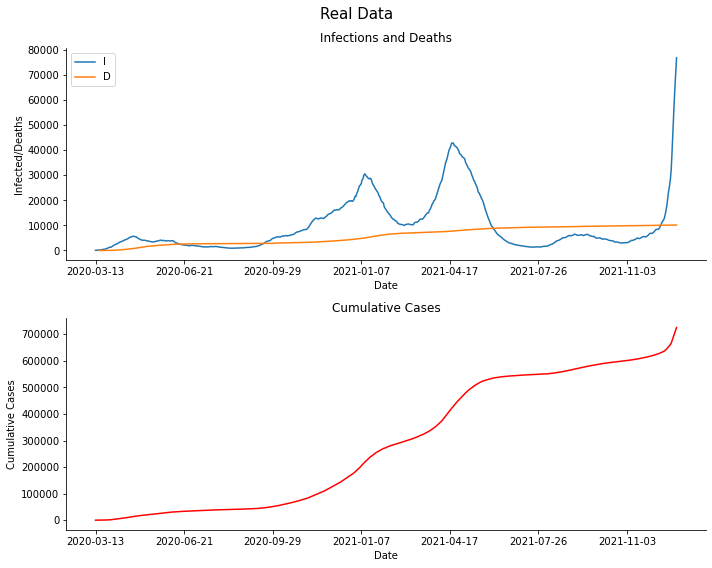

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(covid_data["Date"], covid_data["infections"], label="I")
ax[0].plot(covid_data["Date"], covid_data["deaths"], label="D")
ax[0].set_xticks(np.arange(0, len(covid_data), 100))
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(covid_data["Date"], covid_data["total"], color="red")
ax[1].set_xticks(np.arange(0, len(covid_data), 100))
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)

ax[0].legend()
fig.suptitle("Real Data", fontsize=15)
plt.tight_layout()

Looking at the output for the SIR model and the actual data, it is clear that the SIR does a fairly decent job at replicating the impact of COVID-19 in Ontario. Although there are obviously some in inaccuracies from the model, such as the totals, the general shape and pattern for infections, deaths, cumulative burden hold.

Then below we will begin to look at the effects of differing policies. This will be done, again by effectively changing the effective reproduction rates during various blocks of time. Although this method fails in generating completely different scenarios from what has been done in Ontario, due to the nature of using reproduction rate data, it can still give some insight on variations in what has been done in Ontario. An advantage with using the Ontario data for the reproduction rate, is that we are able to easily incapsulate many other COVID related variables like behaviour, which would be difficult to capture. 

To begin let’s generate some following policy scenarios, which differ from the first scenario that was formed with the SIR model – which we will call the “baseline” case. The first scenario will consist of a tighter hold on COVID at the start but will gradually ease its policies/lockdown procedures as time goes on, beginning its easing around the time of vaccination rollouts (early 2021). On a more technical note, the following procedure will be done by increasing and decreasing the effective reproduction rate at various times in the data. The data in this case will be split into six blocks:

* Pre
* Stage 1
* Stage 2 
* Stage 3
* Stage 4
* Post

Therefore, the beginning time blocks stage 1 and 2 will experience a decrease in the effective reproduction rate, which we can attribute to tighter policy, among other factors, and then in the latter blocks the effective reproduction rate will increase at a greater rate than the actual reproductive rate. Putting the following procedure together we get the following graph for scenario 1.

## Simulate some scenarios

### Scenario 1
Moderate policy that loosens over time

In [14]:
R0new = re_estimates.loc[:, ["date_start", "Re"]].set_index("date_start")

In [15]:
pre = R0new.loc["2020-03-13":"2020-04-01", "Re"]
stage1 = R0new.loc["2020-04-02":"2020-09-01", "Re"] - 0.035
stage2 = R0new.loc["2020-09-02":"2020-12-31", "Re"] - 0.03
stage3 = R0new.loc["2021-01-01":"2021-05-01", "Re"] + 0.01
stage4 = R0new.loc["2021-05-02":"2021-09-01", "Re"] + 0.02
post = R0new.loc["2021-09-02":, "Re"] + 0.03

scenario1 = pd.concat([pre, stage1, stage2, stage3, stage4, post])

In [16]:
Rt1 = lambda t: np.interp(t, t_vec, scenario1)
i_path1, c_path1, d_path1, r_path1, s_path1 = solve_path(Rt1, alpha, t_vec, x_0)

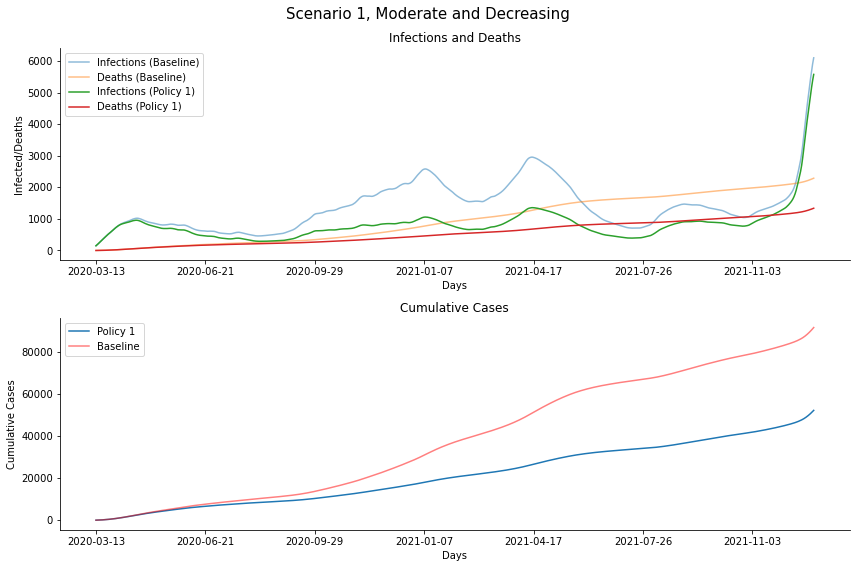

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(dates, i_path * pop, label="Infections (Baseline)", alpha=0.5)
ax[0].plot(dates, d_path * pop, label="Deaths (Baseline)", alpha=0.5)
ax[0].plot(dates, i_path1 * pop, label="Infections (Policy 1)")
ax[0].plot(dates, d_path1 * pop, label="Deaths (Policy 1)")
ax[0].set_xticks(np.arange(0, len(re_estimates), 100))
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(dates, c_path1 * pop, label="Policy 1")
ax[1].plot(dates, c_path * pop, label="Baseline", alpha=0.5, color="red")
ax[1].set_xticks(np.arange(0, len(re_estimates), 100))
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)

ax[0].legend()
ax[1].legend()
fig.suptitle("Scenario 1, Moderate and Decreasing", fontsize=15)
plt.tight_layout()

Right off the bat it is clear that in the first scenario we have lower infection and death rates. Only in the end of the dataset do we see infections skyrocket, as in the baseline, and almost completely catching up to the baseline rates. However, looking at cumulative cases, we see that our first scenario performs exceptionally better than the baseline, leaving around 39,000 less cases by the end of the data range than in the baseline case. Therefore, the result of this scenario shows that the more aggressive start to COVID policy in the beginning, before vaccination rollouts began, resulted in better overall outcomes even with more lenient policy later on, after vaccine rollouts.

### Scenario 2

Harsh policy at the start but then becomes super relaxed

In [18]:
pre = R0new.loc["2020-03-13":"2020-04-01", "Re"]
stage1 = R0new.loc["2020-04-02":"2020-09-01", "Re"] - 0.2
stage2 = R0new.loc["2020-09-02":"2020-12-31", "Re"] - 0.2
stage3 = R0new.loc["2021-01-01":"2021-05-01", "Re"] + 0.25
stage4 = R0new.loc["2021-05-02":"2021-09-01", "Re"] + 0.2
post = R0new.loc["2021-09-02":, "Re"] + 0.2

scenario2 = pd.concat([pre, stage1, stage2, stage3, stage4, post])

In [19]:
Rt2 = lambda t: np.interp(t, t_vec, scenario2)
i_path2, c_path2, d_path2, r_path2, s_path2 = solve_path(Rt2, alpha, t_vec, x_0)

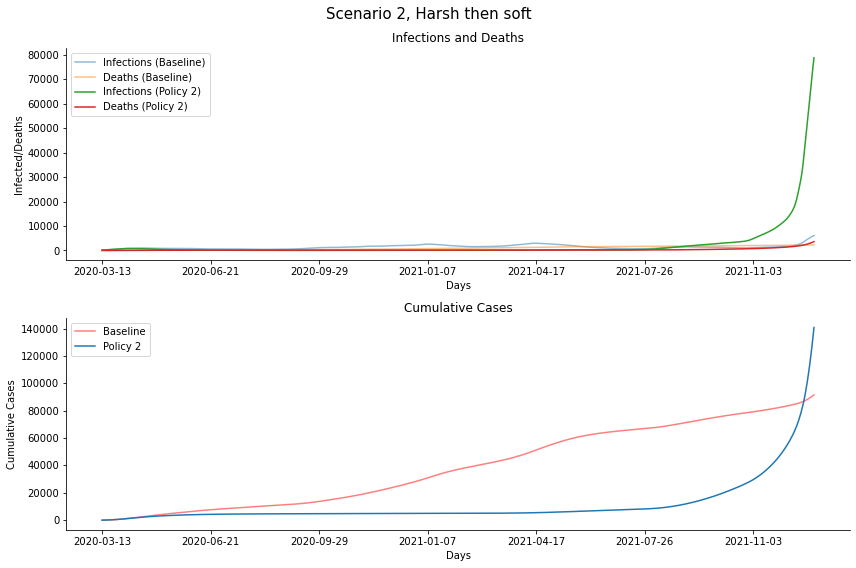

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(dates, i_path * pop, label="Infections (Baseline)", alpha=0.5)
ax[0].plot(dates, d_path * pop, label="Deaths (Baseline)", alpha=0.5)
ax[0].plot(dates, i_path2 * pop, label="Infections (Policy 2)")
ax[0].plot(dates, d_path2 * pop, label="Deaths (Policy 2)")
ax[0].set_xticks(np.arange(0, len(re_estimates), 100))
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(dates, c_path * pop, color="red", label="Baseline", alpha=0.5)
ax[1].plot(dates, c_path2 * pop, label="Policy 2")
ax[1].set_xticks(np.arange(0, len(re_estimates), 100))
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)

ax[0].legend()
ax[1].legend()
fig.suptitle("Scenario 2, Harsh then soft", fontsize=15)
plt.tight_layout()

Moving to scenario 2, here we will simulate a policy that starts off extremely harsh, but then eases off completely. This means that lockdowns and other things such as mask mandates, lift after the very tight lock on COVID. In this case the government will implement at much stricter lockdown for the first year of the pandemic, but after 2020, restrictions will be lifted almost completely, allowing the effective reproduction rate to increase by around 0.2 points. The resulting graph from this particular case is almost illegible due to the magnitude of the infection rate spike at the end of the dataset. We also see a clear increase in the total cases, as it climbs and surpasses the total cases in the baseline case.

### Scenario 3

Block policies

In [21]:
pre = R0new.loc["2020-03-13":"2020-04-01", "Re"]
stage1 = R0new.loc["2020-04-02":"2020-09-01", "Re"] - 0.1
stage2 = R0new.loc["2020-09-02":"2020-12-31", "Re"] + 0.15
stage3 = R0new.loc["2021-01-01":"2021-05-01", "Re"] + 0.1
stage4 = R0new.loc["2021-05-02":"2021-09-01", "Re"] - 0.1
post = R0new.loc["2021-09-02":, "Re"] + 0.05

scenario3 = pd.concat([pre, stage1, stage2, stage3, stage4, post])

In [22]:
Rt3 = lambda t: np.interp(t, t_vec, scenario3)
i_path3, c_path3, d_path3, r_path3, s_path3 = solve_path(Rt3, alpha, t_vec, x_0)

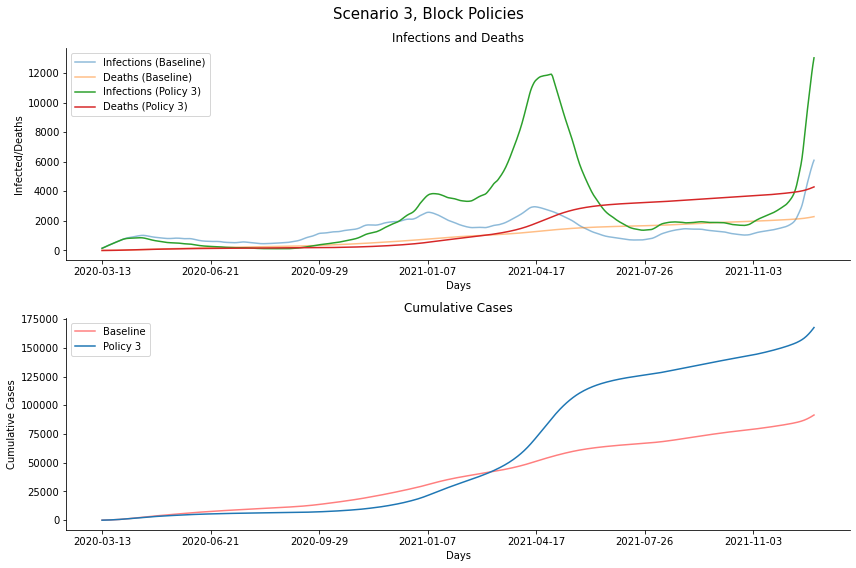

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(dates, i_path * pop, label="Infections (Baseline)", alpha=0.5)
ax[0].plot(dates, d_path * pop, label="Deaths (Baseline)", alpha=0.5)
ax[0].plot(dates, i_path3 * pop, label="Infections (Policy 3)")
ax[0].plot(dates, d_path3 * pop, label="Deaths (Policy 3)")
ax[0].set_xticks(np.arange(0, len(re_estimates), 100))
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(dates, c_path * pop, color="red", label="Baseline", alpha=0.5)
ax[1].plot(dates, c_path3 * pop, label="Policy 3")
ax[1].set_xticks(np.arange(0, len(re_estimates), 100))
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)

ax[0].legend()
ax[1].legend()
fig.suptitle("Scenario 3, Block Policies", fontsize=15)
plt.tight_layout()

For scenario 3 we will look at what will be called “block” policies. This scenario will follow a series of harsh lockdowns followed by very lenient policies. From the third policy we see that it stays below the baseline in the beginning (given the more stringent policy) however, after that period our policy 3 loses control. The result is that by all three metrics, the third policy is remains above our baseline case.

### No Lockdown

In [24]:
R0_no = 1.5

In [25]:
Rtno = lambda t: np.interp(t, t_vec, R0_no)
i_path_no, c_path_no, d_path_no, r_path_no, s_path_no = solve_path(R0_no, alpha, t_vec, x_0)

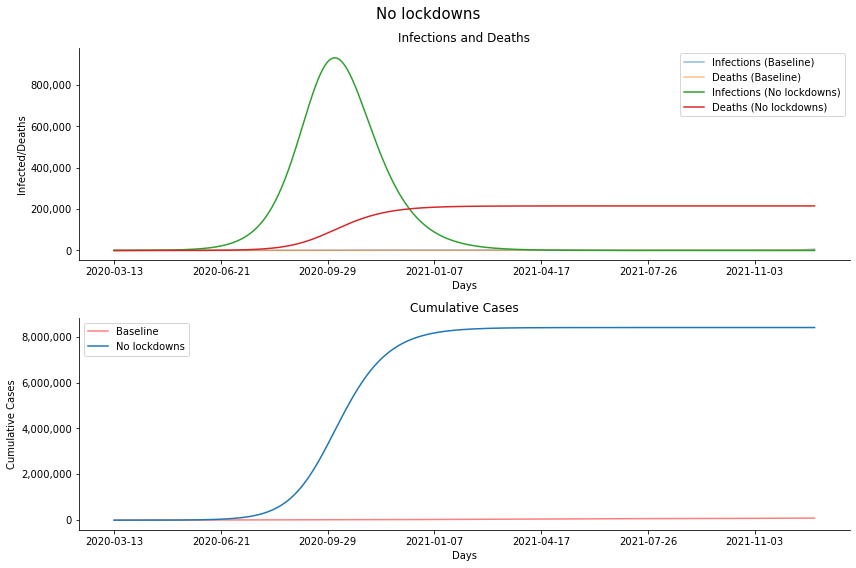

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(dates, i_path * pop, label="Infections (Baseline)", alpha=0.5)
ax[0].plot(dates, d_path * pop, label="Deaths (Baseline)", alpha=0.5)
ax[0].plot(dates, i_path_no * pop, label="Infections (No lockdowns)")
ax[0].plot(dates, d_path_no * pop, label="Deaths (No lockdowns)")
ax[0].set_xticks(np.arange(0, len(re_estimates), 100))
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Infected/Deaths")
ax[0].set_title("Infections and Deaths")
ax[0].spines[["top", "right"]].set_visible(False)
ax[0].yaxis.set_major_formatter('{x:,.0f}')

ax[1].plot(dates, c_path * pop, color="red", label="Baseline", alpha=0.5)
ax[1].plot(dates, c_path_no * pop, label="No lockdowns")
ax[1].set_xticks(np.arange(0, len(re_estimates), 100))
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Cumulative Cases")
ax[1].set_title("Cumulative Cases")
ax[1].spines[["top", "right"]].set_visible(False)
ax[1].yaxis.set_major_formatter('{x:,.0f}')

ax[0].legend()
ax[1].legend()
fig.suptitle("No lockdowns", fontsize=15)
plt.tight_layout()

And for comparison we run situation with no lockdowns at all, where the effective reproduction rate remains at 2.0 for the whole duration. Visually we can see that this leads to incredibly different results from our previous scenarios.

# Calculating Costs

### Looking at GDP

Now we can begin to calculate some of the costs of the pandemic and the policies. Pulling GDP data from StatsCan for the province of Ontario, we can look at how GDP has been growing the past years, including the negative growth in 2020. From this we can look at how much we have lost in term of potential GDP output, in 2020. In order to create somewhat of a counter factual analysis, we will have to estimate a level of GDP that Ontario could have potentially made during 2020 if the pandemic had not happened. We can also present multiple potential growth rates to see how big the difference the output would have been in at various level so growth. The result is plotted in the plot below, where we have four different growth rate levels, ranging from 1 percent to 7 percent growth. Then taking the difference between the potential and actual output we can calculate a loss (or the cost of reduced production during the pandemic). Starting at the lowest growth rate of 1 percent, we can see that a resulting output loss of around \\$45 billion, increasing the growth all the way to our very high end of, an amazing, 7 percent growth we can see a shocking loss of around \\$90 billion.

In [27]:
gdp = pd.read_excel("ONGDP.xlsx")

In [28]:
gdp.columns=["year", "GDP"]
gdp1 = gdp.set_index("year")

In [29]:
growthrates = np.arange(1.01, 1.08, 0.02)

In [30]:
# Lets assume a 3% growth rate
gdp2020 = []

for growthrate in growthrates:
    gdp2020.append(gdp1.loc[2019, "GDP"] * growthrate)

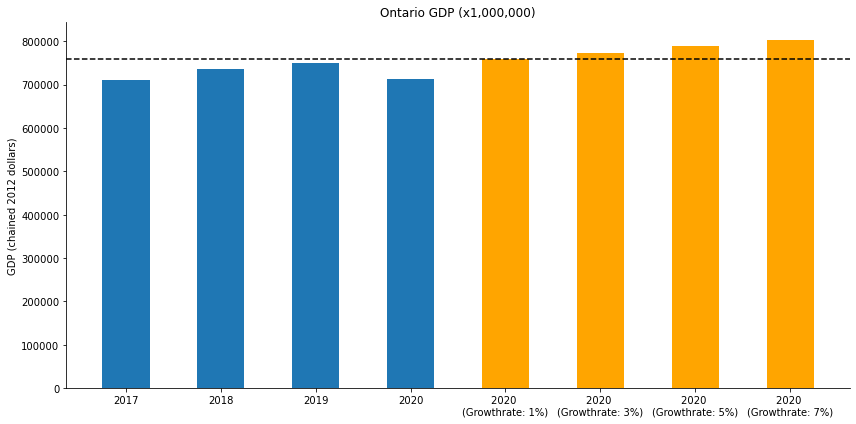

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(["2017", "2018", "2019", "2020"], gdp1["GDP"], width=0.5)
for i, g in zip(range(7), growthrates):
    ax.bar(f"2020 \n(Growthrate: {(g-1)*100:.0f}%)", gdp2020[i], color="orange", width=0.5)
    
ax.spines[["top", "right"]].set_visible(False)
ax.axhline(gdp2020[0], linestyle="--", color="black")
ax.set_ylabel("GDP (chained 2012 dollars)")
plt.title("Ontario GDP (x1,000,000)")
plt.tight_layout()

In [32]:
# Loss in poetential GDP due to COVID-19
for gdp in gdp2020:
    potential = gdp - gdp1.loc[2020, "GDP"]
    print(f"GDP loss from COVID-19 is around: ${potential * 1000000:,.2f}")

GDP loss from COVID-19 is around: $44,856,728,000.00
GDP loss from COVID-19 is around: $59,872,584,000.00
GDP loss from COVID-19 is around: $74,888,440,000.00
GDP loss from COVID-19 is around: $89,904,296,000.00


### Using the VSL

In [33]:
vsl = 4000000
death_costs = []
death_paths = [d_path * pop, d_path1 * pop, d_path2 * pop, d_path3 * pop, d_path_no * pop]

In [34]:
for d in death_paths:
    death_costs.append(d * vsl)

In [35]:
for i in range(5):
    print(f"${death_costs[i].max():,.2f} scenario {i}")

$9,151,016,582.12 scenario 0
$5,349,374,196.64 scenario 1
$14,434,278,396.82 scenario 2
$17,192,317,459.98 scenario 3
$861,981,820,441.00 scenario 4


Another way we can calculate a cost of the pandemic is in the form of lives lost and the value of a statistical life (VSL). From here we can use the calculated number of deaths from each policy scenario, along with the VSL in Canada to produce a cost of the deaths from the pandemic. Using the work from Viscusi (2005), we can calculate the value of a life saved in Canada will come to around \\$4 million. After performing the simple calculations, we can see that the total cost of deaths from the pandemic under each policy regime as the following:

* \\$9,151,016,582.12 Baseline

* \\$5,349,374,196.64  Scenario 1
* \\$14,434,278,396.82 Scenario 2
* \\$17,192,317,459.98 Scenario 3
* \\$861,981,820,441.00 No Lockdown

We can also see below the number of lives saved per policy scenario. To no surpise, we can see that scenario 1 (policy 1) is the highest performing policy; lowest cost and consequently, highest number of lives saved.

* Lives saved: 213,208 Baseline

* Lives saved: 214,158 Scenario 1
* Lives saved: 211,887 Scenario 2
* Lives saved: 211,197 Scenario 3

In [36]:
for i in range(4):
    print(f"Lives saved: {death_paths[4].max() - death_paths[i].max():,.0f}")

Lives saved: 213,208
Lives saved: 214,158
Lives saved: 211,887
Lives saved: 211,197


In [37]:
noLockdown_costs = death_costs[4].max()

for i in range(4):
    print(f"Cost savings in scenario {i}: ${noLockdown_costs - death_costs[i].max():,.2f}")

Cost savings in scenario 0: $852,830,803,858.88
Cost savings in scenario 1: $856,632,446,244.36
Cost savings in scenario 2: $847,547,542,044.18
Cost savings in scenario 3: $844,789,502,981.02


Again, to do a counter factual analysis here, we can look at the benefit of enacting each one of our policies by comparing the VSL calculated cost of the policies with the VSL cost given no policy intervention. The following calculations then show that the policies have the following benefits measured in dollars. We can clearly see that scenario 1 holds the highest benefit.

* Cost savings in Baseline: \\$852,830,803,858.88

* Cost savings in scenario 1: \\$856,632,446,244.36
* Cost savings in scenario 2: \\$847,547,542,044.18
* Cost savings in scenario 3: \\$844,789,502,981.02

The costs of lives lost are also plotted in the graph below for visual pleasure.

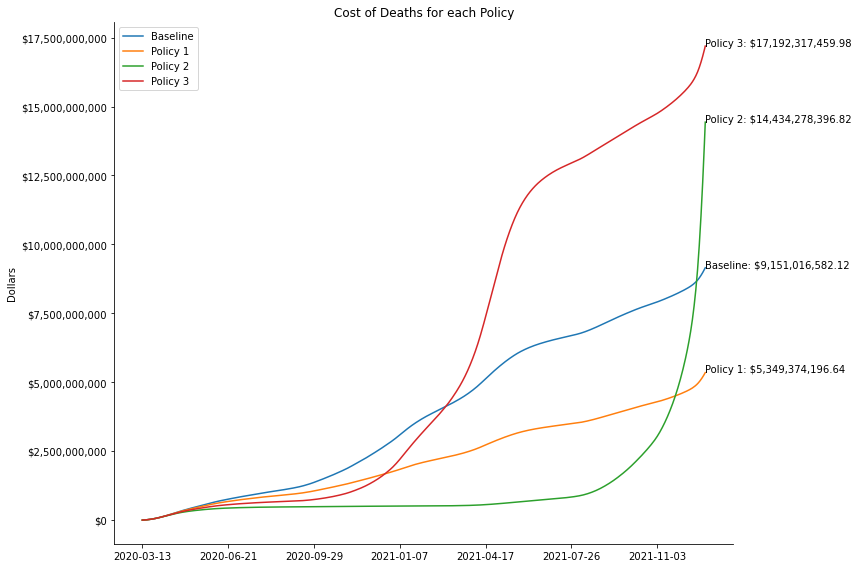

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

cost_labels = ["Baseline", "Policy 1", "Policy 2", "Policy 3"]
for cost, label in zip(range(4), cost_labels):
    ax.plot(dates, death_costs[cost], label=label)
ax.set_xticks(np.arange(0, len(death_costs[0]), 100))
ax.spines[["top", "right"]].set_visible(False)
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_ylabel("Dollars")
ax.legend()

plt.text("2021-12-29", death_costs[0].max(), f"Baseline: ${death_costs[0].max():,.2f}")
plt.text("2021-12-29", death_costs[1].max(), f"Policy 1: ${death_costs[1].max():,.2f}")
plt.text("2021-12-29", death_costs[2].max(), f"Policy 2: ${death_costs[2].max():,.2f}")
plt.text("2021-12-29", death_costs[3].max(), f"Policy 3: ${death_costs[3].max():,.2f}")

plt.title("Cost of Deaths for each Policy")
plt.tight_layout()

# Conclusions

From these results it is clear that even the benefits of worst performing policy far outweighed the cost of lockdown policies. Even at a staggering 7 percent growth rate the net benefits of scenario 3 (worst performing scenario) is around \\$755 billion. We can also see that the first scenario is clearly the winner, as the best performing policy. This means that a stricter lockdown at the beginning of the pandemic would have been more effective at curving the virus, even with more lenient policies after vaccinations rollouts. However, in saying this there are several major issues with this analysis. The first is the fact that we are using reproductive rate data. This does not allow for a true counter factual analysis, as policies and their effects are baked into the result of the data that has been used. The model used in this paper, also makes general assumptions about the virus which remain constant overtime, such as the rate of recovery and the death rate. In a much richer model, these factors would be dynamic, as the virus takes its course. Nonetheless, this exercise does give some insight on potential tweaks that could have been made to the policies which were used during the pandemic, garnering some utility for the future.

# References

Effective reproduction number (Re) for COVID-19 in Ontario - Effective reproduction number (Re) - Ontario Data Catalogue. (2020). Data.ontario.ca. https://data.ontario.ca/dataset/effective-reproduction-number-re-for-covid-19-in-ontario/resource/1ffdf824-2712-4f64-b7fc-f8b2509f9204

School, H. (2005). THE VALUE OF LIFE. http://www.law.harvard.edu/programs/olin_center/papers/pdf/Viscusi_517.pdf

Statistics Canada. (2019). Gross domestic product (GDP) at basic prices, by industry, provinces and territories, growth rates (x 1,000,000). Statcan.gc.ca. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610040202

Status of COVID-19 cases in Ontario - Status of COVID-19 cases in Ontario - Ontario Data Catalogue. (2020). Data.ontario.ca. https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11